In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import math as m
from itertools import product
import time as t

from matplotlib import pyplot as plt

In [3]:
from da_utils import plot_diff_all, plot_gem0_scan, write_gem0_offline, write_gem0_fromfile, write_gem0_fromcpo

In [4]:
xlabels = ['te_value', 'ti_value', 'te_ddrho', 'ti_ddrho']
ylabels = ['te_transp_flux', 'ti_transp_flux']

n_fts=8

In [ ]:
### To create GEM0 scan files:

date_now = '20240201'

#file_in = "../../muscle3/ref_train_data_5000.csv"
#file_in = "gem0_new_data_20231215.csv"
#file_in = "gem0py_lhc_20240110_all.csv"

# coming back to 5000 full grid GEM0 data
#file_in = "gem0_new_data_20231208.csv"
# ... but on corrected radial locations
#file_in = "gem0_new_data_20231215.csv"
# ... newly generated such reading
file_in = 'gem0py_new_20240201.csv'
# LHC sample of size 12000
#file_in = 'gem0py_new_20240123.csv'

modtype="gpr"
codename="gem0py"

### Read inputs
data = pd.read_csv(file_in)
data_x = data[xlabels]
data_y = data[ylabels]
x = np.array(data_x)

# Create scan files
print("Creating scan files")

remainder_file_path = f"scan_{codename}{modtype}_remainder_"
remainder_file_date = date_now
st_t = t.time()

scan_data = [[plot_gem0_scan(x,input_number=i,output_number=o, flag_plot=False, file_name_suf=date_now, extend_factor=0.05, \
                               cut_option='file', remainder_values=f"{remainder_file_path}{xlabels[i]}_{remainder_file_date}", \
                             ) for i in range(len(xlabels))] for o in range(len(ylabels))]
print("Time to create scan files: ", t.time()-st_t)

scan_data_perft = []

# Reshape dictionaries
for n_ft in range(n_fts):
     scan_data_perft.append({(f"{xlabels[i]}_{ylabels[j]}",k): scan_data[j][i][(f"ft{n_ft}",k)] for i,j,k in product(range(len(xlabels)),range(len(ylabels)),['x','y'])})	

# Write down scan files
#date_last = '20240116'

for n_ft in range(n_fts):
     s = scan_data_perft[n_ft]
     spd = pd.DataFrame.from_dict(s)
     spd.to_csv(f"scan_{codename}py_{date_now}_ft{n_ft}.csv")


In [ ]:
# # Test: reading a multi-indexed dataframe
# test_df = pd.read_csv("scan_gem0_remainder_te_value.csv", header=[0, 1], index_col=0,)

# test_df = test_df[(f"ft{0}", xlabels[0])]

# test_array = np.array(test_df)
# print(test_array)

In [ ]:
# To create surrogate scan files:

#!cd ../../../EasySurrogate && pip install . && cd tests/gem_gp && for((i=0;i<8;i++)); do python3 test_model_ann.py ${i} 20231218 && cp scan_${i}.csv ../../../MFW/uq/basicda/scan_gem0surr_20240105_ft${i}.csv ; done && cd ../../../MFW/uq/basicda

!cd ../../../EasySurrogate && pip install . && cd tests/gem_gp && for((i=0;i<8;i++)); do python3 test_model.py ${i} 20231212 && cp scan_${i}.csv ../../../MFW/uq/basicda/scan_gem0surr_20240105_ft${i}.csv ; done && cd ../../../MFW/uq/basicda


In [10]:
# To plot the difference between GEM0 and surrogate, and their comparison

date = '20240201'
surtype = 'gpr'
codename = 'gem0py'

file_pref_gem0 = f"{codename}py_{date}"
file_pref_surr = f"{codename}{surtype}_{date}"

save_file = f"{codename}vs{surtype}_{date}_0.pdf"

plot_diff_all(file_pref_1=file_pref_gem0, file_pref_2=file_pref_surr, save_file=save_file)

!mv *gem0pyvsgpr_20240201_0.pdf ../../..

In [ ]:
# To generate a dataset of LHCS GEM0 evaluations
#nft = 8
date = '20240125'

file_in = 'gem0py_new_20240123.csv'

save_filename=f"gem0py_lhc_{date}_ft"

n_samples_p_ft = 1500

for i in range(n_fts):
    
    print(f"flux tube number: {i}")

    write_gem0_offline(n_samples=n_samples_p_ft, n_ft=i, filename=save_filename, file_in=file_in)


In [ ]:
# To generate an expanded dataset of GEM0 evaluations

from da_utils import write_gem0_expanded

datenow = '20240126'
save_filename = f"gem0py_new_{datenow}.csv"

file_old = "gem_648_data.csv"

expand_factor = 1.0

write_gem0_expanded(file_old, save_filename, expand_factor=expand_factor, calloption=2)

In [ ]:
# Add new readings to a training data set

from da_utils import merge_result_csv

code="gem0py"

date_old = "20240126"
date_new = "20240129"
date_now = "20240129"

file_old = f"{code}_new_{date_old}.csv"
file_new = f"test_{code}_{date_new}.csv"
file_tot = f"{code}_new_{date_now}.csv"

merge_result_csv([file_old, file_new], file_tot)


In [ ]:
# To generate a dataset of GEM0 evaluations for given input file

from da_utils import write_gem0_fromfile

# 1) Testing an new point saved by a workflow during the run
# filename_in = 'new_surrogate_points_it98.csv'
# filename_out = 'test_gem0py_20240129.csv'

# 2) A sample generated as a full grid around the final point of the worflow
# ATTENTION: last coretransp, coreprof, equilibrium have to be copied to /uq/basicda/
date = '20240202'
filename_in = f"gem0py_newpoint_{date}.csv"
filename_out = f"gem0py_new_{date}.csv"

write_gem0_fromfile(filename_in, filename_out)


In [8]:
# temporary: merge generated csv file into one, adding a column with the flux tube number

import glob

date = '20240125'
path = f"gem0py_lhc_{date}_ft*.csv" 

all_files = glob.glob(path)
df_from_each_file = [pd.read_csv(f) for f in all_files]

for i in range(len(df_from_each_file)):
    df_from_each_file[i]['ft'] = i

df_merged = pd.concat(df_from_each_file, ignore_index=True, sort=False)
df_merged.to_csv( f"gem0py_lhc_{date}_all.csv")


In [ ]:
# copy EasySurrogate campaign objects and replace model objects

In [ ]:
# Reformating: read the M3-WF resulting CSV and save the last point in format row: values, columns: Te/i gradTe/i ft

#import re

naming_map = {
    'te_value' : 'Te',
    'ti_value' : 'Ti',
    'te_ddrho' : 'dTe',
    'ti_ddrho' : 'dTi',
    'te_transp_flux': 'flux-Te',
    'ti_transp_flux': 'flux-Ti',    
    'diff_te': 'diff-Te',
    'diff_ti': 'diff-Ti',
    'vconv_te': 'vconv-Te',
    'vconv_ti': 'vconv-Ti',
}

dateorig = '20240202'
datenow  = '20240202'
code = 'gem0'
file_in = f"res_{code}_{dateorig}.csv"
file_out = f"final_point_{code}_{datenow}.csv"

#def find(name, data=data): return [ s for s in np.array(data.columns) if re.findall(name, s) ]

header = [v+'-ft'+str(j) for (k,v),j in product(naming_map.items(),range(1,9))]

data = pd.read_csv(file_in, sep=' ', header=None, names=header, usecols=[i for i in range(len(header))])

#print(header) ###DEBUG
#print(data.iloc[0]) ###DEBUG
#print(data.describe()) ##DEBUG

last_ind = -1
last_reading = data.iloc[last_ind]

nfts = 8

data_list_new = []

for i in range(nfts):

    element = {x:last_reading[f"{naming_map[x]}-ft{i+1}"] for x in xlabels}
    element['ft'] = i

    data_list_new.append(element)

data_new = pd.DataFrame(data_list_new)
data_new.to_csv(file_out)


In [ ]:
# Call pyGEM0 for single file - test why calling it for CPO and a value differs!

dateorig = '20240201'
datenow  = '20240201'
code = 'gem0'

file_in = f"final_point_{code}_{datenow}.csv"
file_out = f"test.csv"

pr_filename = 'gem0_coreprof_in.cpo'
eq_filename = 'gem0_equilibrium_in.cpo'
tr_filename = 'gem0_coretransp_in.cpo'

write_gem0_fromcpo(pr_filename, eq_filename, tr_filename)

write_gem0_fromfile(file_in, file_out)

In [ ]:
# Create a new full-product grid of profile values around a given point

from da_utils import write_profs_fromfile_grid

date = '20240202'

file_in  = f"final_point_gem0_{date}.csv"
file_out = f"gem0py_newpoint_{date}.csv"

write_profs_fromfile_grid(file_in, file_out, num_steps=2)

0

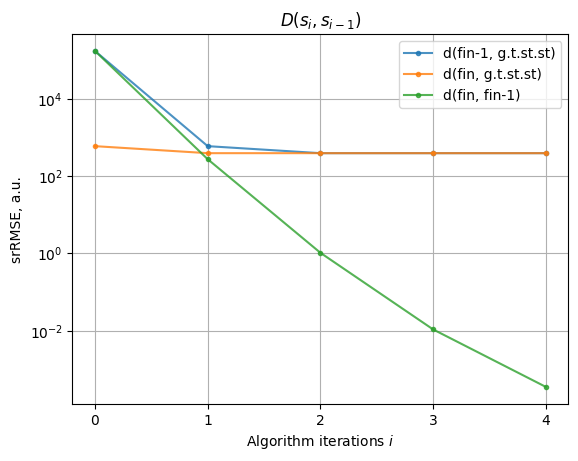

In [22]:
# Plot convergence of state disctance for Retraining algo
import sys
sys.path.append(f"/u/yyudin/code/MFW/muscle3/src/")
from muscle_utils.utils import plot_state_conv

filename = 'retr_algo_conv'

data_df = pd.read_csv(f"{filename}.csv")

plot_state_conv(data_df, filename, normalised=False)


In [21]:
# # Save data on the Retraining algo convergence

# data_dict = {
#     'it'               : [0, 1, 2, 3, 4,],
#     'd_prevfin_gtstst' : [176495.8859822613, 603.4057452947857, 396.9942234314026, 396.9009948076408, 396.90088219565587,],
#     'd_fin_gtststs'    : [603.4057452947857, 396.9942234314026, 396.9009948076408, 396.90088219565587, 396.90089323357563,],
#     'd_prevfin_fin'    : [177104.3934354466, 277.10771108302293, 1.0398953618411646, 0.01074603640113972, 0.00034824677236947895],
# }

# data_df = pd.DataFrame(data_dict)
# data_df.to_csv(f"{filename}.csv")

In [15]:
# # Testing the ProfileCPODecoder

# import os

# import easyvvuq as uq

# from base.profile_cpo_decoder import ProfileCPODecoder

# test_run_file = 'test_easyvvuq'
# test_run_dir = os.path.abspath(test_run_file)

# decoder = ProfileCPODecoder(cpo_filename='ets_coreprof_out.cpo')

# qoi = decoder.parse_sim_output({'run_dir':test_run_dir})

# print(qoi)

{'te_value_0': 1720.00051697186, 'ti_value_0': 1727.2526321474}


In [ ]:
# To get the idea of flux variance as a fnction of rho (and temeperatures, gradients,...)

ft_coords = [0.143587306141853 , 0.309813886880875 , 0.442991137504578 , 0.560640752315521 , 0.668475985527039 , 0.769291400909424 , 0.864721715450287 , 0.955828309059143]

alpha_transp = 0.5

species = ['i', 'e']
filenames = [f"resuq_main_t{sp}_transp_flux_all_csldvnei_43.csv" for sp in species]

data_dfs = [pd.read_csv(filename) for filename in filenames]

n_params = 4
n_p_p_d = 3
n_s_p_ft = n_p_p_d ** n_params
n_fts = 8
    
# ATTENTION: to geat real average w.r.t. prior uncertainty on profiles, use wieght from  G-Legendre quadrature (n=3)
mean_weights_1d = [0.5555555555555556, 0.8888888888888888, 0.5555555555555556]
mean_weights_full = [m.prod(x) for x in product(mean_weights_1d, repeat=n_params)]
weighted_avg = lambda data,valcol,weightcol: (data[valcol]*data[weightcol]).sum() / data[weightcol].sum()
# -> looks like wighting does not change much

for data_df,sp in zip(data_dfs, species):

    # add ft column
    data_df = data_df.reindex(columns=data_df.columns.tolist() + ['ft'])
    for n_ft in range(n_fts):
        data_df['ft'].iloc[n_s_p_ft*(n_ft):n_s_p_ft*(n_ft+1)]= n_ft
    
    # Get the average of t?_transp_flux_std for ft
    colname1 = f"t{sp}_transp_flux_std"
    t_transp_flux_stds = [data_df[data_df['ft']==n_ft][colname1].mean() for n_ft in range(n_fts)]

    colname2 = f"t{sp}_transp_flux"
    t_transp_flux_avgs = [data_df[data_df['ft']==n_ft][colname2].mean() for n_ft in range(n_fts)]

    t_transp_flux_covs = [std/avg for std,avg in zip(t_transp_flux_stds, t_transp_flux_avgs)]

    # Output
    print(f"naive CoV for Q{sp}:\n{t_transp_flux_covs}")
    #plt.plot(ft_coords, t_transp_flux_covs, label=f"unweighted naive CoV[Q_{sp}]", marker='.', alpha=alpha_transp)

    # Inverse the sum and division operations!
    colname3 = f"t{sp}_transp_flux_cov"
    data_df[colname3] = data_df[colname1] / data_df[colname2]
    t_transp_flux_tcovs = [data_df[data_df['ft']==n_ft][colname3].mean() for n_ft in range(n_fts)]
    print(f"unweighted CoV for Q{sp}:\n{t_transp_flux_wcovs}")
    #plt.plot(ft_coords, t_transp_flux_wcovs, label=f"unweighted CoV[Q_{sp}]", marker='.', alpha=alpha_transp)

    # Add weight column
    data_df = data_df.reindex(columns=data_df.columns.tolist() + ['weight'])
    for n_ft in range(n_fts):
        data_df['weight'].iloc[n_s_p_ft*(n_ft):n_s_p_ft*(n_ft+1)] = mean_weights_full

    # Get weighted average of t?_transp_flux_std for ft
    t_transp_flux_wstds  = [weighted_avg(data_df[data_df['ft']==n_ft], colname1, 'weight') for n_ft in range(n_fts)]
    t_transp_flux_wavgs  = [weighted_avg(data_df[data_df['ft']==n_ft], colname2, 'weight') for n_ft in range(n_fts)]
    t_transp_flux_twcovs = [weighted_avg(data_df[data_df['ft']==n_ft], colname3, 'weight') for n_ft in range(n_fts)]
    t_transp_flux_wcovs = [std/avg for std,avg in zip(t_transp_flux_wstds, t_transp_flux_wavgs)]

    print(f"weighted naive CoV for Q{sp}:\n{t_transp_flux_wcovs}")
    #plt.plot(ft_coords, t_transp_flux_wcovs, label=f"weighted naive CoV[Q_{sp}]", marker='.', alpha=alpha_transp)

    print(f"weighted CoV for Q{sp}:\n{t_transp_flux_wcovs}")
    plt.plot(ft_coords, t_transp_flux_twcovs, label=f"CoV[Q_{sp}]", marker='.', alpha=alpha_transp)

plt.legend(loc='best')
plt.grid()

#plt.xlabel(f"flux tube number")
plt.xlabel(f"$\\rho_{{tor}}^{{norm}}$")
plt.ylabel(f"CoV, fraction of the mean")
plt.title(f"Marginalised Aleatoric Coefficient of Variation for Heat Flux")

plt.savefig('gem_flux_cov_pft.pdf')